In [13]:
# Install the requirements.txt file

In [14]:
# Import base packages
import os
import pandas as pd
import numpy as np

#### Data Identification

In [17]:
# Identify the files and import the data
folder_path = "./Data/NLP Disaster Tweets/"
files = os.listdir(folder_path)

print(files) # Train, Test, and a sample for submission

['sample_submission.csv', 'test.csv', 'train.csv']


In [19]:
# Open the 'train.csv'
train_csv = pd.read_csv(folder_path+files[-1])
train_csv.sample(5)

,id,keyword,location,text,target
2891,4154,drown,East Coast,We all carry these things inside that no one e...,0
179,256,ambulance,"Cambridge, MA",New Nanotech Device Will Be Able To Target And...,0
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
5457,7784,police,NaN,Police: Man killed ex grandmother after son wa...,1
4077,5795,hail,Arkansas,Strong Thunderstorm 4 Miles North of Japton Mo...,1


In [20]:
# Test too
test_csv = pd.read_csv(folder_path+files[1])

In [21]:
# We'll want to get a good measure on the amount of "NaN"'s present
train_csv.isna().sum() 

# Most NaN's are located within the 'location' section, probably meaning no location
# was tagged in the tweet.
# We are missing some keywords though, thankfully just a small amount

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [22]:
# Let's look closer at the NaN keyword tweets, could be a pattern of some kind
nan_keyword_txts =  train_csv[train_csv["keyword"].isna()]

# All missing keyword texts are also missing their locations
nan_keyword_txts.isna().sum()

id           0
keyword     61
location    61
text         0
target       0
dtype: int64

In [23]:
# Check types
train_csv.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

#### Text Cleaning & Pre-processing

In [24]:
# Start with the original dataset, I need to do a few things:
# 1) Get a count of keywords and see what's common
# 2) Clean the 'text' column of unecessary characters, I'll do this in a function so I can apply the
#    other df to it as well
# 3) Tokenize the clean text and start to look for patterns within both
# 4) Since this is a classification model, I'll need some way of classifying the text, I may just use a 
#    random forrest or a K-means here... worry about later.

In [25]:
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt

In [26]:
# One thing for sure is that several keywords have a "%20" where a space would be, I'll have to clean up the text and such first 
# before I move any further...

# To clean up the keywords, locations, and text, I can create a function to do so or make use of pandas calls
# If I plan to employ this on my website, I may need a function running to allow for user inputs to be cleaned
# before they get tested by the model

In [27]:
# Sample tweets
train_csv["text"].sample(3)

626    Government Experts Concerned About Possible Bi...
977    å_? New Ladies Shoulder Tote #Handbag Faux Lea...
613    Firepower in the lab [electronic resource] : a...
Name: text, dtype: object

In [28]:
# Sample locations
train_csv["location"].sample(3)

6204                             NaN
7393    (a) property of the universe
2496                             NaN
Name: location, dtype: object

In [29]:
# Sample keywords
train_csv["keyword"].sample(3)

6704      thunder
3879    flattened
1460     casualty
Name: keyword, dtype: object

In [30]:
# For cleaning up the keyword
def keyCleaner(key):    
    try:
        # Strip unwanted text
        key = key.replace("%20", " ")

        # all lowercase
        key = key.lower()
        return key
    except AttributeError:
        pass

# Next the text portion (the actual tweet)
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def removePunct(text):
    # I want to remove all punct for the sake of vectorization later
    pattern = r"[!@#$%^&*()_+=\[\]{};\'\\:|<,./?><]"
    
    text_without_punctuation = re.sub(pattern, '', text)
    return text_without_punctuation

def lowerCase(text):
    text = text.lower()
    return text

In [31]:
# Apply the function of the keywords column
train_csv["keyword"] = train_csv["keyword"].apply(lambda key: keyCleaner(key))

# Apply the other functions to the text for both train & test
lst = [train_csv, test_csv]
for df in lst:
    df["text"] = df["text"].apply(lambda text: remove_URL(text))
    df["text"] = df["text"].apply(lambda text: remove_html(text))
    df["text"] = df["text"].apply(lambda text: remove_emoji(text))
    df["text"] = df["text"].apply(lambda text: lowerCase(text))
    df["text"] = df["text"].apply(lambda text: removePunct(text))

# Tailor the function to be able to process locatioon and the tweet itself
# Maybe something can be done with the location that can be aimed at helping taylor the classification?

In [32]:
# Collects the words for the WordCloud
def create_corpus(tweet, target):
    # For the non-target ones too
    events = []

    # Gather target word for a disaster
    for x in tweet[tweet['target'] == target]['text'].str.split():
        for i in x:
            events.append(i)
    return events

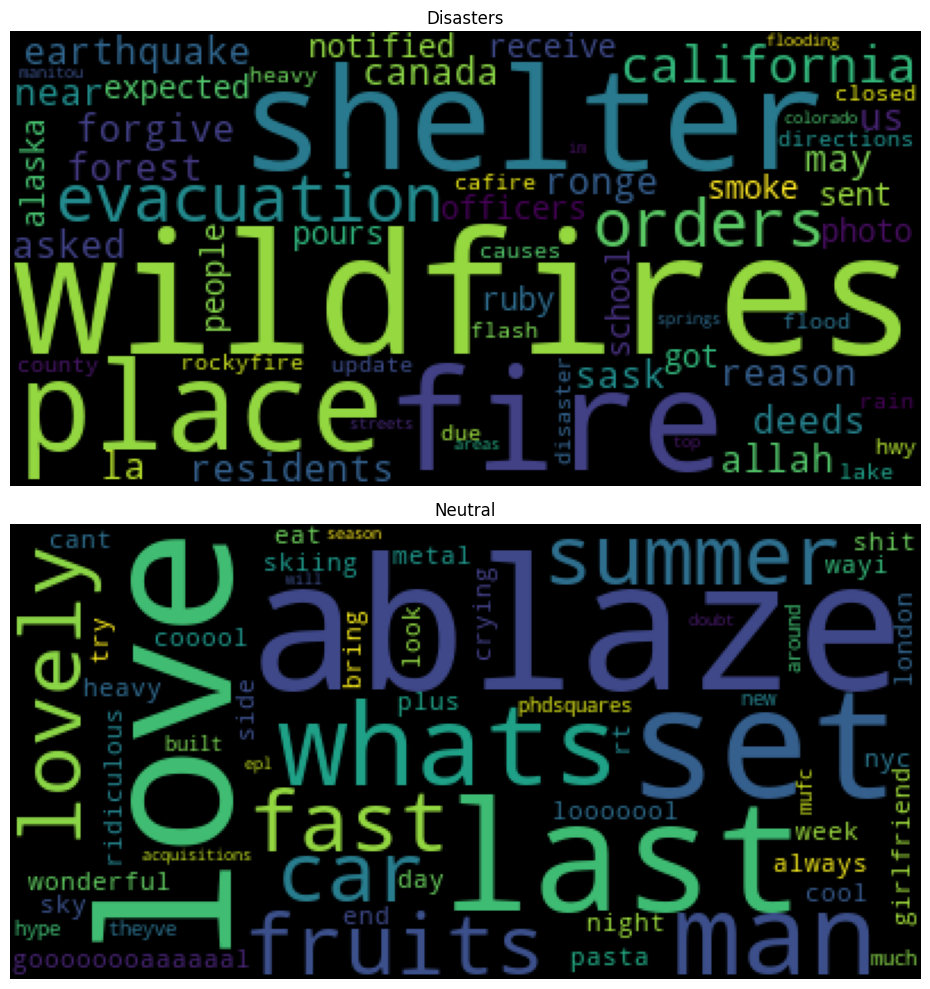

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Create a wordcloud of the tweet targets from the "train_csv"
disaster = create_corpus(train_csv, 1)
neutral = create_corpus(train_csv, 0)

word_cloud_disaster = WordCloud(max_font_size=80).generate(" ".join(disaster[:100]))
word_cloud_neutral = WordCloud(max_font_size=80).generate(" ".join(neutral[:100]))

ax[0].imshow(word_cloud_disaster)
ax[0].axis('off')
ax[0].set_title("Disasters")

ax[1].imshow(word_cloud_neutral)
ax[1].axis('off');
ax[1].set_title("Neutral")
plt.tight_layout()

In [34]:
# Looks like the "Disasters" have more negative-themed words, that we can use to our advantage

#### Adding more data - Sentiment Analysis

In [35]:
# Before I go any further, I want to consider sentiment analysis as another column that
# could help the classification model make a better suggestion...

# Several different types exist, one I may consider for this since it's social media is
# VADER - Valence Aware Dictionary and sEntiment Reasoner

# The thought for me here is to get information based on the positivity, negativity, or neutrality
# of the text. I can use those values as a way to train the model for assessment later.

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a function that presses each text against VADER and create a column using the outputs

# Create the object
sid_obj = SentimentIntensityAnalyzer()
def vader(text):
    # Read the text into the analyzer
    vader_dict = sid_obj.polarity_scores(text)

    # Return the dict (values can be accessed)
    return vader_dict

In [37]:
# If we wanted to try a different analysis, copy the df
train_csv_VADER, test_csv_VADER = train_csv.copy(), test_csv.copy()

# Apply the function to the dataset
sent_lst = [train_csv_VADER, test_csv_VADER]
for df in sent_lst:
    df["negative"] = df["text"].apply(lambda t: vader(t)["neg"])
    df["neutral"] = df["text"].apply(lambda t: vader(t)["neu"])
    df["positive"] = df["text"].apply(lambda t: vader(t)["pos"])

    # Final "combination" section
    df["compound"] = df["text"].apply(lambda t: vader(t)["compound"])

In [38]:
# Dictionaries for storing the count of either 0 or 1 for each sentiment category - Just training

pos_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["positive"] >= 0.3].groupby("target").count()["positive"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["positive"] >= 0.3].groupby("target").count()["positive"][0]}

neg_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["negative"] >= 0.3].groupby("target").count()["negative"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["negative"] >= 0.3].groupby("target").count()["negative"][0]}

neut_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["neutral"] >= 0.3].groupby("target").count()["neutral"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["neutral"] >= 0.3].groupby("target").count()["neutral"][0]}

combined_dict = {"Disaster (1)": train_csv_VADER[train_csv_VADER["compound"] >= 0.3].groupby("target").count()["compound"][1],
            "Nothing (0)": train_csv_VADER[train_csv_VADER["compound"] >= 0.3].groupby("target").count()["compound"][0]}

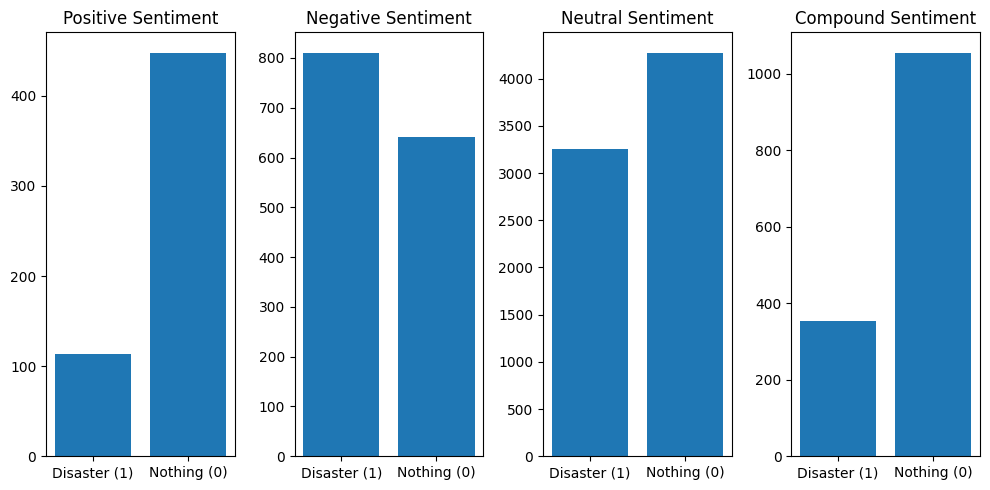

In [39]:
# Lets assess some of the values
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

# Create three graphs (+, -, =) that depict the VADER analysis against the target count
ax[0].bar(pos_dict.keys(), pos_dict.values())
ax[0].set_title("Positive Sentiment")

ax[1].bar(neg_dict.keys(), neg_dict.values())
ax[1].set_title("Negative Sentiment")

ax[2].bar(neut_dict.keys(), neut_dict.values())
ax[2].set_title("Neutral Sentiment")

ax[3].bar(combined_dict.keys(), combined_dict.values())
ax[3].set_title("Compound Sentiment")

plt.tight_layout()

In [40]:
# Tells me that the sentiment analysis is better at detecting the positives (0) than the negatives
# I'd only want to include that "statement positivity" value in the model.

# The 'compound' sentiment leans more positively if the % is over 30%, telling me that although some tweets have
# negativity in them, they have a more positive sentiment. For the sake of modeling, the 'compound' score may help us get the
# best results.

# Remember the goal here is to train a classification model to be capable of descerning this on it's own, I want
# to avoid putting too much info into the model to where overfitting becomes and issue but enough to where
# the model isn't stagnating at a poor accuracy value...

#### Data Splitting

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Prior to vectorizing, lets split the data (X and Y)

# I want to bring over the 'positive' from the Sentiment analysis
X = train_csv_VADER[["text", "positive"]]
y = train_csv_VADER["target"]

# If I want to EXCLUDE any sentiment analysis data...
X_no_sent = train_csv_VADER["text"]

# Testing text
X_test = test_csv_VADER[["text"]]

# Split the data using a 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Vectorization

In [43]:
# Work on tokenizing the tweets
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
# I'll be using TF-IDF vectorizer because this focuses on the combination of frequency as well
# as rarity of words
tfidf = TfidfVectorizer()
train_tfidf_vectors = tfidf.fit_transform(X_train["text"])
val_tfidf_vectors = tfidf.transform(X_val["text"])

In [45]:
# Vectorize test with the trained tfidf
test_tfidf_vectors = tfidf.transform(X_test["text"])

#### Modeling

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# I'd want to do a few models here to assess overall accuracies
# Logistic regression wouldn't be bad here because of the way it classifies, it's either >0.5 or <0.5
# I also want to use a Random Forest for the sake of their applicability to classification

##### -- Logistic Regression --

In [47]:
# From Kaggle -- JY: NLP with Disaster Tweets (Top 15%)
def displayConfusionMatrix(y_true, y_pred, dataset):
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    except Exception as e:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            display_labels=["Not Disaster","Disaster"],
            cmap=plt.cm.Blues
        )
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(3)))

In [48]:
from sklearn.linear_model import LogisticRegression

# Instantiate the model
logit_model = LogisticRegression()

# Fit with the vectorized training set
logit_model.fit(train_tfidf_vectors, y_train)

LogisticRegression()

In [49]:
# Get score on train
logit_model.score(train_tfidf_vectors, y_train)

# Score on val
logit_model.score(val_tfidf_vectors, y_val)

0.8063033486539725

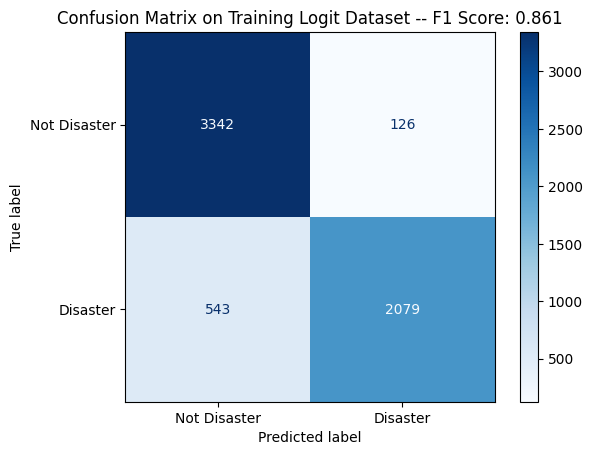

In [50]:
# Confusion matricies
y_pred_train = logit_model.predict(train_tfidf_vectors)

displayConfusionMatrix(y_train, y_pred_train, "Training Logit")

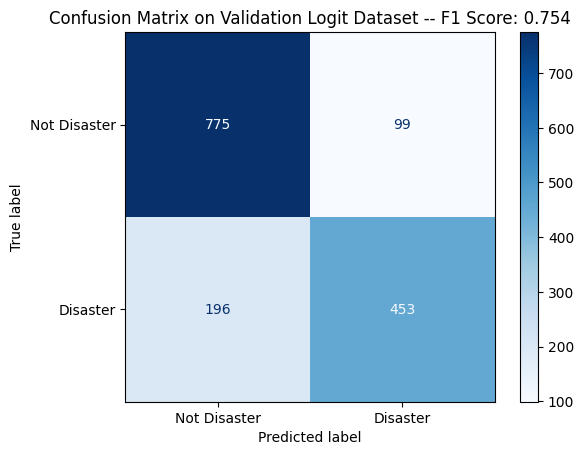

In [51]:
y_pred_val = logit_model.predict(val_tfidf_vectors)

displayConfusionMatrix(y_val, y_pred_val, "Validation Logit")

##### -- Random Forests --